# Evaluation

In [1]:
import torch
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib
import os
import pandas as pd
import anndata as ad
from scipy.stats import pearsonr
from src import utils
import seaborn as sns

In [2]:
path = 'results/epoch_1600/'
results = pickle.load(open(os.path.join(path, 'latents.pkl'), 'rb'))
other = pickle.load(open(os.path.join(path, 'other.pkl'), 'rb'))
data = pd.read_feather('../../data/3t3/data_preprocessed.feather')

# can be downloaded at https://doi.org/10.6084/m9.figshare.15109236.v2.
bento_data = ad.read_h5ad('../../data/3t3/bento_processed.h5ad')

## Data examples

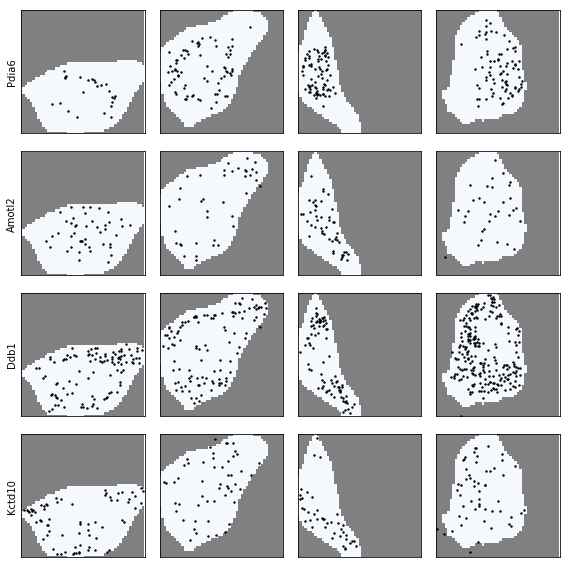

In [3]:
data['gene_id'], _ = pd.factorize(data['gene'])
data['cell_id'], _ = pd.factorize(data['cell'])

data_rescaled = utils.rescale_cells(data)

genes = ['Pdia6', 'Amotl2', 'Ddb1', 'Kctd10']
n_cells = 4

fig, axs = plt.subplots(len(genes), n_cells, figsize=(n_cells*2, len(genes)*2))
cmap = matplotlib.cm.get_cmap('Blues').copy()
cmap.set_under(color='grey')
for i, cell in enumerate(range(n_cells)):
    for j, gene in enumerate(genes):
        
        ax=axs[j, i]
        gene_cell_data = data_rescaled[(data_rescaled.gene==gene) & (data_rescaled.cell==cell)]
        ax.matshow(other['masks'][cell], origin='lower', cmap=cmap, vmin=0.001, vmax=100)
        ax.scatter(gene_cell_data.x * 50, gene_cell_data.y * 50, s=2, c='black')
        ax.set_xlim(0, 50)
        ax.set_ylim(0, 50)
        ax.set_xticks([])
        ax.set_yticks([])
        axs[j, 0].set_ylabel(gene)
        
plt.tight_layout()
plt.show()

## Factors

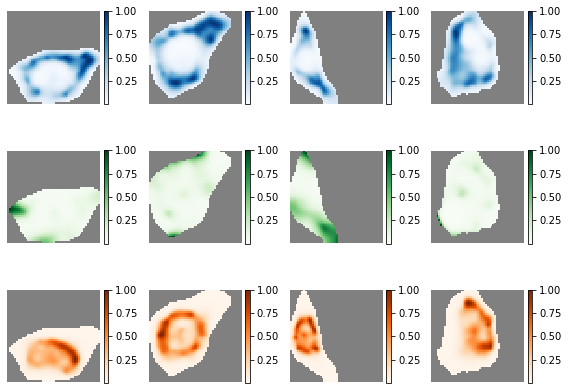

In [4]:
n_cells = 4
n_factors = results['z'].shape[1]

fig, axs = plt.subplots(n_factors, n_cells, figsize=(n_cells*2, n_factors*2))

for cell in range(n_cells):
    for factor in range(n_factors):
        cmap = matplotlib.cm.get_cmap(['Blues', 'Greens', 'Oranges'][factor]).copy()
        cmap.set_under(color='grey')
        z = results['z'][cell, factor]
        z = torch.nan_to_num(z, 0)
        z /= z.max()
        im = axs[factor, cell].matshow(z, origin='lower', cmap=cmap, vmin=1e-5)
        axs[factor, cell].axis('off')
        plt.colorbar(im, ax=axs[factor, cell], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Weights

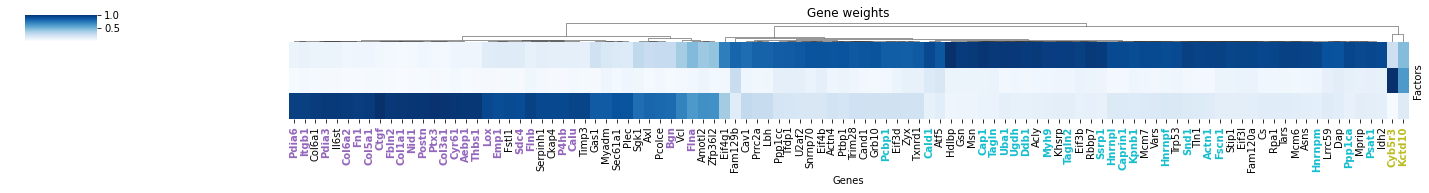

In [5]:
protrusion_genes = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Net1', 'Trak2', 'Kif1c', 'Kctd10', 'Dynll2', 'Arhgap11a', 'Gxylt1', 'H6pd', 'Gdf11', 'Dync1li2', 'Palld', 'Ppfia1', 'Naa50', 'Ptgfr', 'Zeb1', 'Arhgap32', 'Scd1']
nucleus_perinucleus_genes = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn', 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1', 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6', 'Col5a2', 'Itgb1', 'Calu', 'Pdia3', 'Cyr61']
nucleus_sc1_genes = ['Cyr61', 'Thbs1', 'Ctgf', 'Serpine1', 'Ptx3', 'Tnc']
nucleus_sc2_genes = ['Flna', 'Flnb', 'Prec', 'Flnc', 'lqgap1']
nucleus_sc3_genes = ['Bicd2', 'Nin', 'Pcnt', 'Numa1', 'Spdl1', 'Ctif', 'Cep350', 'Trip11', 'Gorasp2']
cytoplasm_genes = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1', 'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1', 'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']

w = results['w']
w /= w.max(dim=0)[0].view(1, w.shape[1])

im =sns.clustermap(w.numpy().T, figsize=(20, 2), row_cluster=False, cmap='Blues')
im.ax_heatmap.set_xlabel('Genes')
im.ax_heatmap.set_ylabel('Factors')
im.ax_heatmap.set_yticks([])
im.ax_col_dendrogram.set_title('Gene weights')
im.ax_heatmap.set_xticks(torch.arange(w.shape[0]) + 0.5)

inds = im.dendrogram_col.reordered_ind
ordered_genes = other['genes'][inds]
ordered_w = w[inds]
im.ax_heatmap.set_xticklabels(ordered_genes, rotation='vertical', size=10)

for i, gene in enumerate(ordered_genes):
    if gene in protrusion_genes:
        im.ax_heatmap.get_xticklabels()[i].set_color('C8')
        im.ax_heatmap.get_xticklabels()[i].set_fontweight('bold')
    if gene in nucleus_perinucleus_genes + nucleus_sc1_genes + nucleus_sc2_genes + nucleus_sc3_genes:
        im.ax_heatmap.get_xticklabels()[i].set_color('C4')
        im.ax_heatmap.get_xticklabels()[i].set_fontweight('bold')
    if gene in cytoplasm_genes:
        im.ax_heatmap.get_xticklabels()[i].set_color('C9')
        im.ax_heatmap.get_xticklabels()[i].set_fontweight('bold')

plt.show()

## Comparison of factors with bento signatures

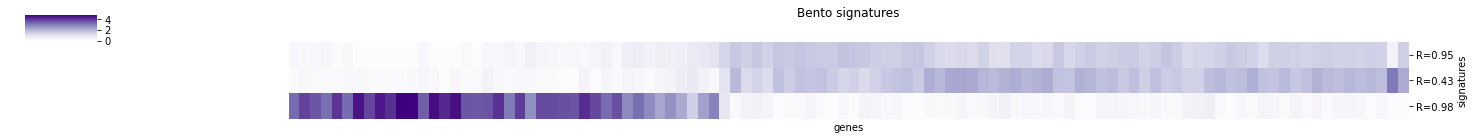

In [6]:
bento_signatures_df = pd.merge(pd.DataFrame({'gene' : ordered_genes}), bento_data.uns['tensor_loadings']['genes'], left_on='gene', right_index=True, how='left')
bento_signatures= bento_signatures_df.iloc[:, 1:].values

inds, _ = utils.optimal_assignment(ordered_w, torch.tensor(bento_signatures), 1)
bento_signatures = bento_signatures[:, inds]

corrs = []
for factor in range(n_factors):
    corrs.append(round(pearsonr(ordered_w[:, factor].numpy(), bento_signatures[:, factor])[0], 2))

im = sns.clustermap(bento_signatures.T, figsize=(20, 2), row_cluster=False, col_cluster=False, cmap='Purples')
im.ax_heatmap.set_xlabel('genes')
im.ax_heatmap.set_ylabel('signatures')
im.ax_heatmap.set_yticks(torch.arange(3) + 0.5,)
im.ax_heatmap.set_yticklabels(['R={}'.format(i) for i in corrs], rotation='horizontal')
im.ax_col_dendrogram.set_title('Bento signatures')
im.ax_heatmap.set_xticks([])
plt.show()